Intel CEO SEC Filings
===

This notebook looks at the insider trades made by the Intel CEO, according to his Form 4 filings.

In [1]:
import bs4
import requests
import re
import xml.etree.ElementTree as ET
import time
import json

In [2]:
def get_paginated_filings_links(start, count):
    search_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
    params={
        'action':'getcompany',
        'CIK':'0001538580', # This is Brian Krzanich's CIK; if you want all of Intel, use '0000050863'
        'type':'',
        'dateb':'',
        'owner':'only',
        'start':start,
        'count':count
    }
    resp = requests.get(search_url, params=params)
    # todo: require 201
    parsed = bs4.BeautifulSoup(resp.text, "html.parser")
    links =[x.get('href') for x in parsed.findAll('a', {'id':'documentsbutton'})]
    return list(map(lambda s: 'https://www.sec.gov' + s[:s.rindex('/')] + '/form4.xml', links))

In [3]:
def process_filing(filing_url):
    # download XML formatted form4
    resp = requests.get(filing_url)
    
    if resp.status_code != requests.codes.ok:
        return None
    
    root = ET.fromstring(resp.text)
    
    data = {}
    
    data['sourceUrl'] = filing_url
    data['reportPeriod'] = root.find('periodOfReport').text

    owner_id_node = root.find('reportingOwner').find('reportingOwnerId')
    data['owner'] = {
            'cik'  : owner_id_node.find('rptOwnerCik').text,
            'name' : owner_id_node.find('rptOwnerName').text
        }
    
    # non-derivative table parsing
    nonderivative_table = []
    if root.find('nonDerivativeTable'):
        for transaction in root.find('nonDerivativeTable').findall('nonDerivativeTransaction'):
            transaction_data = {
                    'securityTitle': transaction.find('securityTitle').find('value').text,
                    'transactionDate' : transaction.find('transactionDate').find('value').text,
                    'code' : transaction.find('transactionCoding').find('transactionCode').text,
                    'numShares' : int(transaction.find('transactionAmounts').find('transactionShares').find('value').text),
                    'sharePrice' : float(transaction.find('transactionAmounts').find('transactionPricePerShare').find('value').text),
                    'postTransactionShares' : int(transaction.find('postTransactionAmounts').find('sharesOwnedFollowingTransaction').find('value').text)
                }

            # num shares is positive if acquired, negative if sold
            acquired = transaction.find('transactionAmounts').find('transactionAcquiredDisposedCode').find('value').text == 'A'
            transaction_data['numShares'] = transaction_data['numShares'] if acquired else -transaction_data['numShares']

            nonderivative_table.append(transaction_data)
    data['nonderivativeTable'] = nonderivative_table
    
    # derivative table parsing
    derivative_table = []
    if root.find('derivativeTable'):
        textify = lambda s: s.text if s is not None else s 
        for transaction in root.find('derivativeTable').findall('derivativeTransaction'):
            transaction_data = {
                    'securityTitle': textify(transaction.find('securityTitle').find('value')),
                    'transactionDate' : textify(transaction.find('transactionDate').find('value')),
                    'code' : textify(transaction.find('transactionCoding').find('transactionCode')),
                    'numShares' : int(transaction.find('transactionAmounts').find('transactionShares').find('value').text),
                    'conversionPrice' : float(transaction.find('conversionOrExercisePrice').find('value').text),
                    'exerciseDate' : textify(transaction.find('exerciseDate').find('value')),
                    'expirationDate' : textify(transaction.find('expirationDate').find('value')),
                    'remainingSecurities' : textify(transaction.find('postTransactionAmounts').find('sharesOwnedFollowingTransaction').find('value'))
                }

            # num shares is positive if acquired, negative if sold
            acquired = transaction.find('transactionAmounts').find('transactionAcquiredDisposedCode').find('value').text == 'A'
            transaction_data['numShares'] = transaction_data['numShares'] if acquired else -transaction_data['numShares']

            derivative_table.append(transaction_data)
    data['derivativeTable'] = derivative_table
        
    return data    

Here, we have the option to rebuild the list of trades (takes about 2 minutes) or just run with the cached results

In [4]:
rebuild_list = False

filings = []
if rebuild_list:
    for link in get_paginated_filings_links(0, 10):
        filings.append(process_filing(link))
        time.sleep(1)

    with open('intel-ceo-filings.json', 'w') as f:
        json.dump(filings, f)
else:
    with open('intel-ceo-filings.json', 'r') as f:
        filings = json.load(f)

Analysis Time!
---

In [5]:
import pandas as pd
import numpy as np
from itertools import groupby
from functools import reduce

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
filtered_filings = [f for f in filings if f is not None]

In [7]:
stock_purchases = [
    (t['transactionDate'], t['numShares'])
    for filing in filtered_filings
    for t in filing['nonderivativeTable']
    if t['numShares'] > 0
]
stock_purchases.sort()

stock_sales = [
    (t['transactionDate'], -t['numShares'])
    for filing in filtered_filings
    for t in filing['nonderivativeTable']
    if t['numShares'] < 0
]
stock_sales.sort()

In [8]:
purchase_data = {}
for k, vs in groupby(stock_purchases, lambda x:x[0]):
    purchase_data[pd.to_datetime(k)] = reduce(lambda a, b: a+b[1], vs, 0)
    
sale_data = {}
for k, vs in groupby(stock_sales, lambda x:x[0]):
    sale_data[pd.to_datetime(k)] = reduce(lambda a, b: a+b[1], vs, 0)

In [47]:
purchase_series = pd.Series(purchase_data)
sale_series = pd.Series(sale_data)

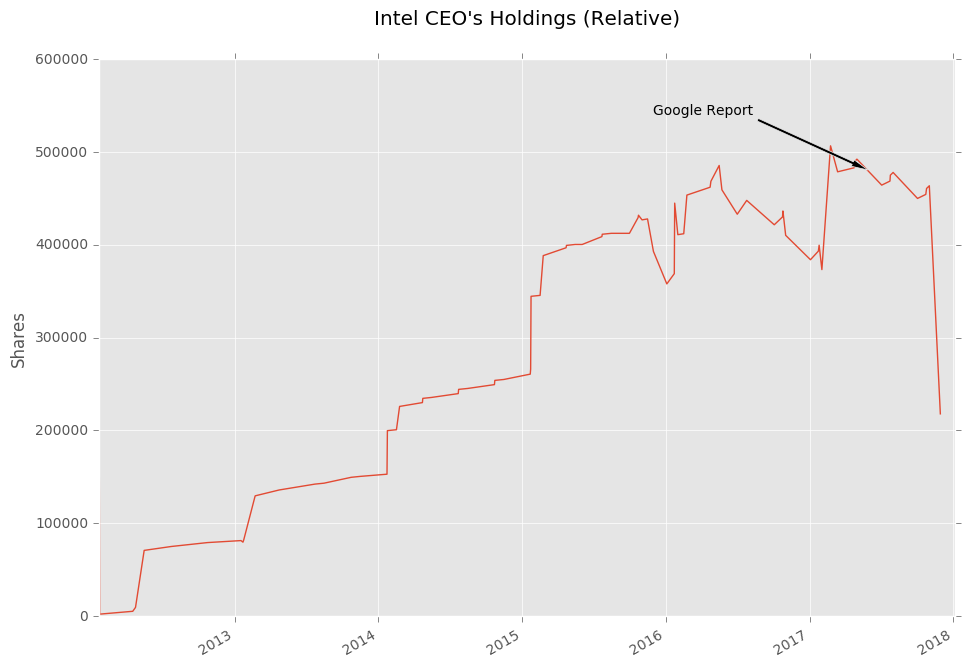

In [90]:
str2ax = lambda s : dates.date2num(pd.to_datetime(s)) # converts datestring to axis point

rel_holdings = (purchase_series.sub(sale_series, fill_value=0)).cumsum()

plt.figure(figsize=(10,7)) 
ax = rel_holdings.plot()

# Title position
ax.set_title('Intel CEO\'s Holdings (Relative)')
ax.title.set_position([.5, 1.05])
ax.set_ylabel('Shares')

ax.annotate('Google Report', xy=(str2ax('2017-06-01'), 480000), xytext=(str2ax('2015-12-01'), 540000),
            arrowprops={'facecolor':'black', 'shrink':0.01, 'width':2, 'headwidth':5},
            )

# add a little buffer
plt.xlim(xmax=str2ax('2018-01-04'))
plt.tight_layout(pad=2)

plt.show()

#plt.savefig('RelativeHoldings.png')